# Final Project - Guitar Sound Extraction

## Submitters
Itay Yona - 312457302 <br>
Michael Kurtzer - 317312130 <br>

## Aim of the project
The aim of project is to extract only the guitar sound of a given sound file.

## Rationale
Entertainment and Educational Purposes (for guitar learning)

We found Machine Learning articles and tools capable of:
- extracting pitch from single-instrument audio file. [1,2]
- translating sheet-notes into guitar tabes. [3]
- recognizing musical instruments [4]

There seems to be a tool missing* for extracting the guitar sound from a song. (Sounds seperation is a difficult problem [5]) <br>
*We have found a tool for instrument sound extraction using non-Machine Learning techniques. [6]

## DataSets Used
http://www.philharmonia.co.uk/explore/sound_samples [7] - this is the raw data for the dataset we will build with a python script. (see Approach below)
<br> We also consider using another dataset [8]
<br> Eventually we used an additional guitar dataset [12]

### Approach
Using the Philharmonia's dataset we will build a supervised learning model identifying the guitar sound out of a mix of instruments audio. <br>
The Philharmonia's dataset contains single notes sounds of several instruments. <br>

Firstly we will combine the notes from the dataset to create a mix of instruments. <br>
Our labels will be the guitar notes. <br>
We will build a neural network based on this labeled data and let it extract the guitar-track from songs. <br>

### Algorithm
Convolutional Neural Networks - a lot of published research regarding audio and ML have used CNNs as their main model. <br>

### Packages 
PyDub <br>
TensorFlow <br>
LibRosa <br>
Keras <br>

## Preliminary Results
We were able to use pydub to mix serveral notes creating a dataset for training. (In the code below)

### Why CNNs*?
CNNs are widely used for audio pattern analysis. [9,10]

CNNs can discriminate spectro-temporal patterns, meaning they are able to capture patterns across time and frequency given input spectograms. <br>
This is important for distinguishing noise-like sounds, like the sounds that might appear in our dataset. <br>
<br>
They have an edge over traditional mel-frequncy cepstral coeffs [11] as the CNNs are able to make distinctions even
when the sound is masked by other noise. <br>
<br>
The main drawback of CNNs is the need of a huge dataset for training. <br>
this is not an issue for us since we are able to create data as much as we want! <br>
another solution is using data-augmentation: changing the audio just slightly that it still has the same label, but creating a new audio for the network. <br>

#### footnote:
*<i>After some more research and our pratical experiments, we discovered that it is better to use MPLC (multilayer perceptron classifier).</i>

## Research Diary & Results
1. the first challenge was getting the dataset <br>
2. looking for libraries
3. mixing the sounds
4. FFT
    - we couldn't use the STFT results for our model.
    - we've got nice pics though :-)
5. plotting wavelength
6. training a model - 98% success rate!
7. mixing the sound attempt - we took only the 1.5 - 3 seconds ~ 89.11% over TESTING set
8. mixing the sounds - better idea - trim()
9. sounds were mixed at the same time! ~ 98% success rate!
10. add files with no guitar sounds to training-set.
        problem: looking for classification with default value (aka Out Of Distribution classification)
        option1: using predict probs - V (works! we found threshold)
        option2: binary-classification for guitar (if probs-diffs are insignificant)
        
        trying the model against clarinet / violin works partialy.
            we probably need to train the model with more intrsuments!
            
        the model against flute works perfectly ~ 97% success.
        the model against guitar works good! it has ~ 100% success of classifying only guitar sounds as guitar.
        the model against mandolin (which is basically different guitar) has a 96% success rate.
            this it not good, out model maybe overfitted to the training's set guitar.
            
            
11. build a guitar vs other-instrument model (rather than flute)

        we chose Violin - works great, 100%! :-)
        it also improved the prediction over the flute to 100%!!
        
12. try predicting different guitars sounds!

        got new dataset of an electric guitar!
        the success rate of the new electric guitar is only 6%
    
    

## Discussion
<p> Our trained model has converged to a "parrot" model. Meaning it probably memorized specific characteristics of our guitar. However, it was able to classify with tremendous success rate (~100%). </p>
<p>When introduced to another guitar (an "electric guitar") it had a success rate similiar to a guess. We realized that adding the electric guitar sounds to the training set probably wouldn't change much. This new model will most likely memorize the new sounds and won't be able to generalize to most guitars! </p>
<p>Thus, a new aproach should be taken: Our results show that, seperating different instrument sounds is an easy task for Machine Learning. </p>
<p>We suggest the following solution: one should be using as diverse dataset as possible.
This will force the nerual network to converge into a function with generalization abilities and prevents overfitting over the dataset.</p>

## Conclusions & Personal Prespective
<p>Machine Learning is awesome!</p>
<p> We have tried and researched several aproaches. There seem to be a lot of research around music. We have chose the best aproach based on the problem at hand, our research and practical experiments. We have managed to reach most of our major goals. We had some failures (details in the relevant code sections). We drew many (smaller) conclusions throughout the project, and implemented many fixes and improvments to our project (some of the mistakes were left in the code as examples).</p>
<p>We did not reached our original goal of returning a sound file of guitar only, for every type of guitar. However, we did manage to recongnize if the sample containes a guitar sound and its pitch.</p>

# Code Section

All imports in the project

In [24]:
%pylab inline
import IPython.display as ipd
import pandas as pd
import glob
import librosa
import librosa.display
from pydub import AudioSegment
import pathlib
import os
import os.path
import pprint
import mutagen
import random as randomlib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as MLPC
import functools
from pysndfx import AudioEffectsChain
import scipy.signal

Populating the interactive namespace from numpy and matplotlib


C:\Users\Itay\AppData\Local\Continuum\anaconda2\envs\python3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Building the dataset
Normalizing length, silence, etc..

Songs mixing proof of concept
<br> using pydub

In [1]:
song1 = AudioSegment.from_mp3("dataset/all-samples/clarinet/clarinet_A5_15_fortissimo_normal.mp3") # 19.2KB - 3 seconds
song2 = AudioSegment.from_mp3("dataset/all-samples/guitar/guitar_C4_very-long_forte_normal.mp3") # 49.4 KB - 4 seconds
output = song1.overlay(song2)
output2 = song2.overlay(song1)
output.export("dataset/mixes/mixed.mp3", format="mp3") # 17.6 KB - 3 seconds
output2.export("dataset/mixes/mixed2.mp3", format="mp3") # 32.0 KB - 4 seconds

<_io.BufferedRandom name='dataset/mixes/mixed2.mp3'>

Guitar and Flute sounds mix

In [324]:
# takes 2 lists of files path
# mix files, 1 from each list
def mix_sounds(guitar_sounds, sounds2, output_dir):
    
    for guitar_track in guitar_sounds:
        s1 = AudioSegment.from_mp3(guitar_track)
        guitar_track_name = pathlib.Path(guitar_track).stem

        print(guitar_track_name, end=" ")
        for instrument2_track in sounds2:
            instrument2_track_name = pathlib.Path(instrument2_track).stem
            output_path = output_dir + "/" + guitar_track_name + instrument2_track_name + '.mp3'

            if os.path.exists(output_path):
                continue

            s2 = AudioSegment.from_mp3(instrument2_track)

            # output = s1.overlay(s2)
            output = s2.overlay(s1)
            tags= { "sound1" : guitar_track_name , "sound2" : instrument2_track_name }
            output.export(output_path, format="mp3", tags=tags)
            
    print("done...")

In [404]:
guitar_sounds = glob.glob("dataset/all-samples/my_guitar/*.mp3")
flute_sounds = glob.glob("dataset/all-samples/my_flute/*.mp3")

mix_sounds(guitar_sounds, flute_sounds, "dataset/mixes2")

guitar_A2_very-long_forte_normal guitar_A3_very-long_forte_normal guitar_A4_very-long_forte_normal guitar_As2_very-long_forte_normal guitar_As3_very-long_forte_normal guitar_As4_very-long_forte_normal guitar_B2_very-long_forte_normal guitar_B3_very-long_forte_normal guitar_B4_very-long_forte_normal guitar_C3_very-long_forte_normal guitar_C4_very-long_forte_normal guitar_Cs3_very-long_forte_normal guitar_Cs4_very-long_forte_normal guitar_D3_very-long_forte_normal guitar_D4_very-long_forte_normal guitar_D5_very-long_forte_normal guitar_Ds3_very-long_forte_normal guitar_Ds4_very-long_forte_normal guitar_Ds5_very-long_forte_normal guitar_E2_very-long_forte_normal guitar_E3_very-long_forte_normal guitar_E4_very-long_forte_normal guitar_E5_very-long_forte_normal guitar_F2_very-long_forte_normal guitar_F3_very-long_forte_normal guitar_F4_very-long_forte_normal guitar_Fs2_very-long_forte_normal guitar_Fs3_very-long_forte_normal guitar_Fs4_very-long_forte_normal guitar_G2_very-long_forte_normal

An attempt exactly overlaying the guitar and flute sounds 

In [297]:
guitar_sounds = glob.glob("dataset/all-samples/my_guitar/*.mp3")
flute_sounds = glob.glob("dataset/all-samples/my_flute/*.mp3")

GUITAR_START = 1500
GUITAR_END = 3000

for instrument1 in guitar_sounds:
    s1 = AudioSegment.from_mp3(instrument1)[GUITAR_START:GUITAR_END]
    s1_name = pathlib.Path(instrument1).stem
    
    print(s1_name)
    for instrument2 in flute_sounds:
        s2_name = pathlib.Path(instrument2).stem
        output_path = "dataset/mixes3/" + s1_name.replace('.mp3','') + s2_name.replace('.mp3','') + '.mp3'
        
        if os.path.exists(output_path):
            continue
            
        s2 = AudioSegment.from_mp3(instrument2)
        
        
        output = s1.overlay(s2)
        output.export(output_path, format="mp3", tags= { "sound1" : s1_name , "sound2" : s2_name })

print("done...")

guitar_A2_very-long_forte_normal
guitar_A3_very-long_forte_normal
guitar_A4_very-long_forte_normal
guitar_As2_very-long_forte_normal
guitar_As3_very-long_forte_normal
guitar_As4_very-long_forte_normal
guitar_B2_very-long_forte_normal
guitar_B3_very-long_forte_normal
guitar_B4_very-long_forte_normal
guitar_C3_very-long_forte_normal
guitar_C4_very-long_forte_normal
guitar_Cs3_very-long_forte_normal
guitar_Cs4_very-long_forte_normal
guitar_D3_very-long_forte_normal
guitar_D4_very-long_forte_normal
guitar_D5_very-long_forte_normal
guitar_Ds3_very-long_forte_normal
guitar_Ds4_very-long_forte_normal
guitar_Ds5_very-long_forte_normal
guitar_E2_very-long_forte_normal
guitar_E3_very-long_forte_normal
guitar_E4_very-long_forte_normal
guitar_E5_very-long_forte_normal
guitar_F2_very-long_forte_normal
guitar_F3_very-long_forte_normal
guitar_F4_very-long_forte_normal
guitar_Fs2_very-long_forte_normal
guitar_Fs3_very-long_forte_normal
guitar_Fs4_very-long_forte_normal
guitar_G2_very-long_forte_normal

parameter tuning for guitar silence trimming

In [3]:
# TRIM TEST

guitar_sounds = glob.glob("dataset/all-samples/my_guitar/*.mp3")#[:3]
for somefile in guitar_sounds:
# somefile = "dataset/all-samples/my_guitar/guitar_A3_very-long_forte_normal.mp3"
    result_path = "C:/tmp/test.wav"
    #display(ipd.Audio(somefile))

    audio, sr = librosa.load(somefile)
    
    rmse = librosa.feature.rmse(y=audio, frame_length=512, hop_length=128)[0]
    audio_trimmed = librosa.effects.trim(audio, top_db=13, frame_length=4096, hop_length=1024)
    
    #print(librosa.power_to_db(rmse**2, ref=np.max))
    #print(librosa.power_to_db(rmse**2, ref=2))
    
    # librosa.output.write_wav(result_path, audio_trimmed[0], sr)
    
    #print(f"duration {librosa.get_duration(audio)}")
    dur = librosa.get_duration(audio_trimmed[0])
    if dur > 2:
        print(f"duration {dur}")
        display(ipd.Audio(result_path))
        
    #librosa.display.waveplot(audio, sr)
    #librosa.display.waveplot(audio_trimmed[0], sr)

duration 2.414875283446712


duration 2.136235827664399


duration 3.297233560090703


duration 3.297233560090703


duration 2.089795918367347


duration 4.551111111111111


duration 2.2755555555555556


duration 2.414875283446712


duration 2.972154195011338


Guitar trimming silence
<br> using librosa

In [43]:
# TRIM BY SILENCE
# TRIM BY TAKING ONLY 1.5 SECONDS

GUITAR_END = 1500

guitar_sounds = glob.glob("dataset/all-samples/my_guitar/*.mp3")
# manual fixes
# guitar_sounds = [r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\my_guitar\guitar_As4_very-long_forte_normal.mp3"]
# top_db = 10
for instrument1 in guitar_sounds:
    
    s1_name = pathlib.Path(instrument1).stem
    
    output_path_wav = "dataset/all-samples/my_guitar_trimmed/" + s1_name + ".wav"
    output_path_mp3 = "dataset/all-samples/my_guitar_trimmed/" + s1_name + ".mp3"
    
    #if os.path.exists(output_path_wav):
    #    continue
    
    #if os.path.exists(output_path_mp3):
    #    continue
    
    s1,sr = librosa.load(instrument1)
    
    print(s1_name)
    s1_no_silence,sr1 = librosa.effects.trim(s1, top_db=13, frame_length=4096, hop_length=1024)
    librosa.output.write_wav(output_path_wav, s1_no_silence, sr)
    
    wav = AudioSegment.from_wav(output_path_wav)[:GUITAR_END]
    wav.export(output_path_mp3, format="mp3")

guitar_As4_very-long_forte_normal


Mixing trimmed guitar with flute

In [402]:
guitar_sounds = glob.glob("dataset/all-samples/my_guitar_trimmed/*.mp3")
flute_sounds = glob.glob("dataset/all-samples/my_flute/*.mp3")

mix_sounds(guitar_sounds, flute_sounds, "dataset/mixes4")

guitar_A2_very-long_forte_normal guitar_A3_very-long_forte_normal guitar_A4_very-long_forte_normal guitar_As2_very-long_forte_normal guitar_As3_very-long_forte_normal guitar_As4_very-long_forte_normal guitar_B2_very-long_forte_normal guitar_B3_very-long_forte_normal guitar_B4_very-long_forte_normal guitar_C3_very-long_forte_normal guitar_C4_very-long_forte_normal guitar_Cs3_very-long_forte_normal guitar_Cs4_very-long_forte_normal guitar_D3_very-long_forte_normal guitar_D4_very-long_forte_normal guitar_D5_very-long_forte_normal guitar_Ds3_very-long_forte_normal guitar_Ds4_very-long_forte_normal guitar_Ds5_very-long_forte_normal guitar_E2_very-long_forte_normal guitar_E3_very-long_forte_normal guitar_E4_very-long_forte_normal guitar_E5_very-long_forte_normal guitar_F2_very-long_forte_normal guitar_F3_very-long_forte_normal guitar_F4_very-long_forte_normal guitar_Fs2_very-long_forte_normal guitar_Fs3_very-long_forte_normal guitar_Fs4_very-long_forte_normal guitar_G2_very-long_forte_normal

## finished dataset building

# Dataset Visualizations
Awesome part!
<br> This is a visual aid for better human understanding of "musical aspects" of sounds.

Flute & Guitar overlayed waveplot

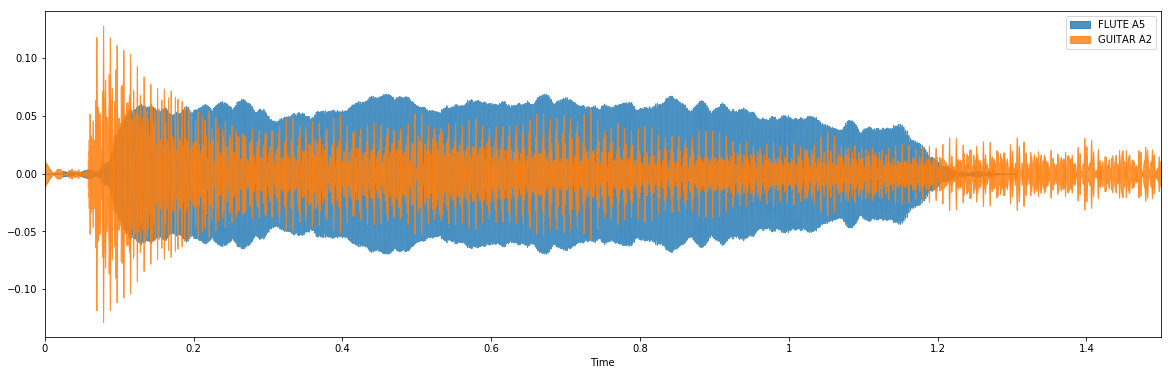

In [10]:
flute_sounds = glob.glob("dataset/all-samples/my_flute/*.mp3")
flute_sound = flute_sounds[0]
flute_note = flute_sound.split('_')[2]

guitar_sounds = glob.glob("dataset/all-samples/my_guitar/*.mp3")
guitar_sounds = glob.glob("dataset/all-samples/my_guitar_trimmed/*.mp3")
guitar_sound = guitar_sounds[0]
guitar_note = guitar_sound.split('_')[3]

flute_data, flute_sr = librosa.load(flute_sound)
guitar_data, guitar_sr = librosa.load(guitar_sound)

plt.figure(figsize=(20, 6))
librosa.display.waveplot(flute_data, sr=flute_sr, alpha=0.8)
librosa.display.waveplot(guitar_data, sr=guitar_sr, alpha=0.8)

plt.legend(['FLUTE ' + flute_note, 'GUITAR ' + guitar_note])
plt.show()

## FFT waves plotting
note: <i>samples are not normalized by time! </i>

In [11]:
def plot_wavelength(fft_sound, sample_rate, max_freq = 1000):
    plt.figure(figsize=(8, 5))
    
    # librosa.display.specshow(fft_sound, sr=sample_rate, y_axis='linear', x_axis='time',  cmap='gray_r')
    librosa.display.specshow(fft_sound, sr=sample_rate, y_axis='linear', x_axis='time')
    
    plt.colorbar(format='%+.2f dB')
    plt.ylim([0, max_freq])
    plt.yticks(range(0, max_freq, 50))
    plt.show()

<h5> Guitar 'A' note, octaves 2,3,4 </h5>
A4 frequency is 440Hz, since guitar is a complex instrument, overtones are added!
<br> overtones are integer multplies of the original frequency.
<br> A3 is 220Hz, but also 440, 660 ...
<br> A2 is 110Hz, but also 220, 330, 440 ...

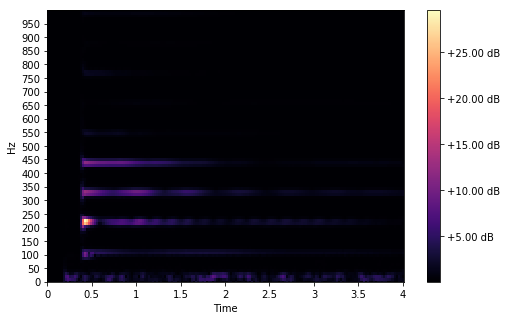

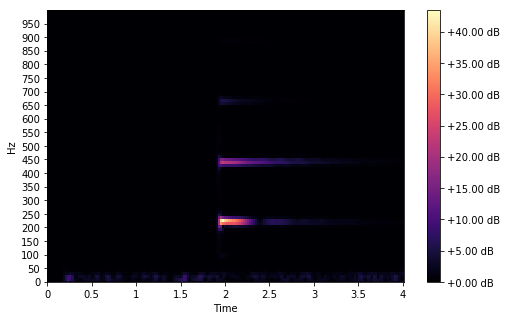

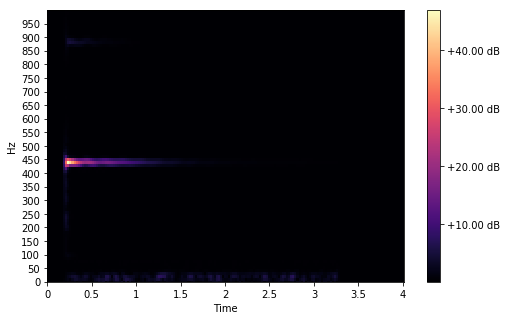

In [319]:
guitar_track1 = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\my_guitar\guitar_A2_very-long_forte_normal.mp3"
guitar_track2 = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\my_guitar\guitar_A3_very-long_forte_normal.mp3"
guitar_track3 = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\my_guitar\guitar_A4_very-long_forte_normal.mp3"

tracks = [guitar_track1, guitar_track2, guitar_track3]
for t in tracks:
    sound, sample_rate = librosa.load(t, duration=4.)
    fft_sound = librosa.stft(sound)
    plot_wavelength(fft_sound, sample_rate)

<h5> Guitar and flute mix </h5>
Same note, same octave - D5
<br> Same note, different octave - G2, G5
<br> Different note, same octave - D5, C5


C:\Users\Itay\AppData\Local\Continuum\anaconda2\envs\python3\lib\site-packages\librosa\display.py:696: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


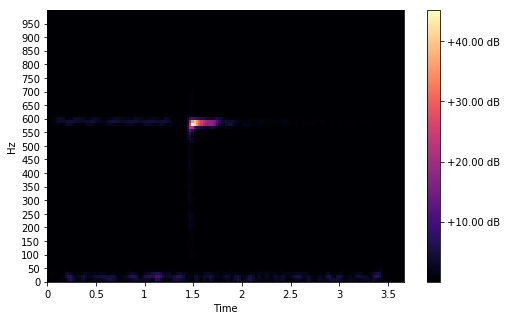

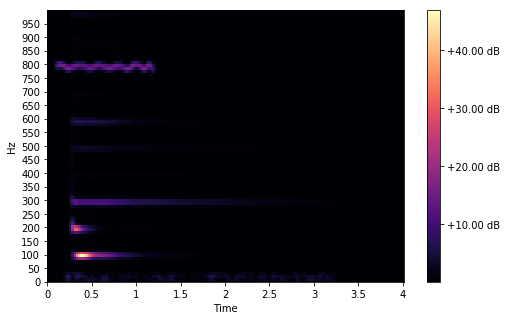

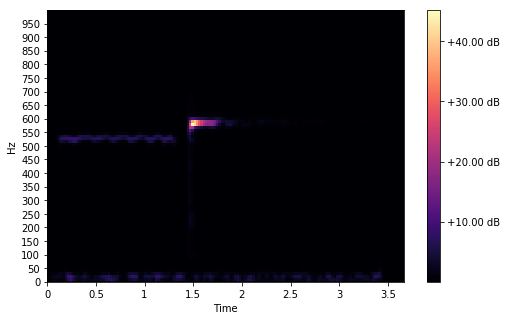

In [12]:
mix_track1 = r"C:\Users\Itay\Documents\university\workshop\dataset\mixes2\guitar_D5_very-long_forte_normalflute_D5_15_forte_normal.mp3"
mix_track2 = r"C:\Users\Itay\Documents\university\workshop\dataset\mixes2\guitar_G2_very-long_forte_normalflute_G5_15_forte_normal.mp3"
mix_track3 = r"C:\Users\Itay\Documents\university\workshop\dataset\mixes2\guitar_D5_very-long_forte_normalflute_C5_15_forte_normal.mp3"

tracks = [mix_track1, mix_track2, mix_track3]
for t in tracks:
    sound, sample_rate = librosa.load(t, duration=4.)
    fft_sound = librosa.stft(sound)
    plot_wavelength(fft_sound, sample_rate)

violin wave plots

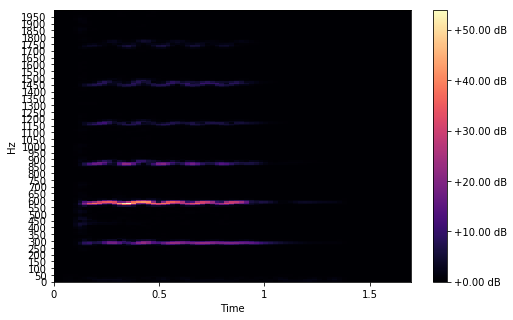

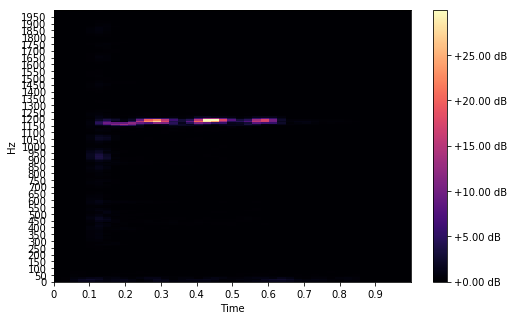

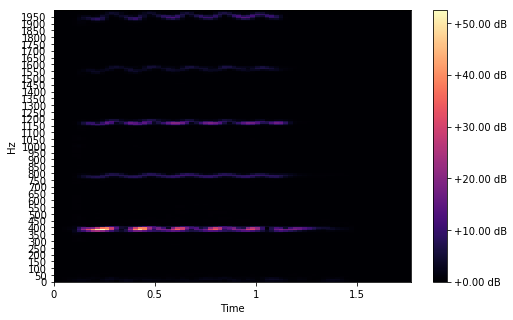

In [13]:
violin_track1 = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\violin\violin_D4_1_forte_arco-normal.mp3"
violin_track2 = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\violin\violin_D6_1_forte_arco-normal.mp3"
violin_track3 = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\violin\violin_G4_1_forte_arco-normal.mp3"

tracks = [violin_track1, violin_track2, violin_track3]
for t in tracks:
    sound, sample_rate = librosa.load(t, duration=4.)
    fft_sound = librosa.stft(sound)
    plot_wavelength(fft_sound, sample_rate, 2000)

mix - guitar E5 & flute E5
<br> guitar - E5
<br> flute - E5

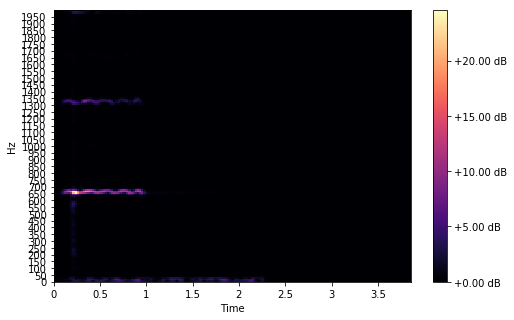

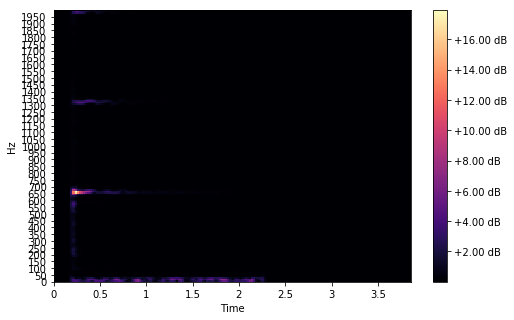

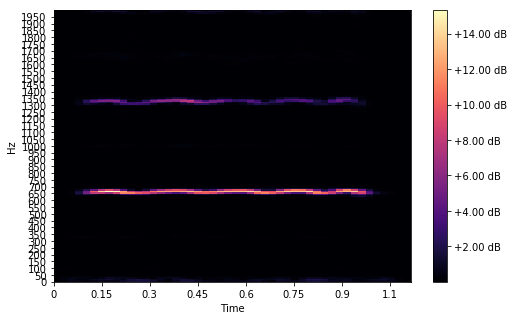

In [14]:
same_time_track = r"C:\Users\Itay\Documents\university\workshop\dataset\mixes2\guitar_E5_very-long_forte_normalflute_E5_15_forte_normal.mp3"
guitar_track = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\guitar\guitar_E5_very-long_forte_normal.mp3"
flute_track = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\flute\flute_E5_15_forte_normal.mp3"

tracks = [same_time_track, guitar_track, flute_track]
for t in tracks:
    sound, sample_rate = librosa.load(t, duration=4.)
    fft_sound = librosa.stft(sound)
    plot_wavelength(fft_sound, sample_rate, 2000)

amplitude waveplot (with playbar display)
<br> the file is a mix of guitar and flute, not at the same time

In [17]:
# based on https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/

mixed_files = glob.glob("dataset/mixes/*.mp3")
somefile = mixed_files[0]

# Shows playbar for audio: ipd.Audio(somefile)
data, sampling_rate = librosa.load(somefile)

plt.figure(figsize=(20, 6))

# librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio(somefile)

<Figure size 1440x432 with 0 Axes>

# Model Building

Dataset randomization
<br> Dataset labeling (labels were set based on file names from the original dataset)

In [141]:
# Randomizing dataset
all_files = glob.glob("dataset/mixes4/*.mp3")
random.seed(2019)
random_files = all_files.copy()
random.shuffle(random_files)

labels = []
for f in random_files:
    l = mutagen.File(f)['TXXX:sound1'].text[0]
    note_octave = l.split('_')[1].upper()
    labels.append(note_octave)
    
print("Done")
print(labels[:10])

Done
['FS3', 'AS4', 'A2', 'A3', 'F4', 'F2', 'DS4', 'F3', 'DS5', 'B4']


Librosa loading takes too much time
<br> Cache was added to improve performance for reloading

In [142]:
@functools.lru_cache(maxsize=4096, typed=False)
def librosa_load_cached(file_name):
    return librosa.load(file_name)

Dataset loading with librosa
<br> Data format: data is sampled with a given sample rate (22050 default)
<br> Each second has 22050 samples
<br> Each frequency (between 0 to 22050) has an amplitude which is the a floating point value

1 Second wave plot for the 1st dataset input


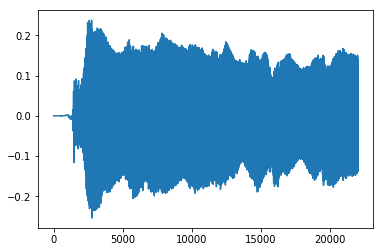

In [362]:
sample_rate = 22050

plt.plot(data_raw[0][:sample_rate])
print("1 Second wave plot for the 1st dataset input")

Librosa loading for all dataset files

In [143]:
data_raw = []
POWERS_OF_TWO = [2 ** i for i in range(16)]

print(f"loading {len(random_files)} files with librosa...")
for i, file_name in enumerate(random_files): # random_files -> all_files
 
    if i in POWERS_OF_TWO:
        print(i, end=" ")
        
    track, sr = librosa_load_cached(file_name)
    data_raw.append(track)

print("\ndone")

loading 962 files with librosa...
1 2 4 8 16 32 64 128 256 512 
done


An attempt to load and calculate FFT for all dataset files
<br> We could calclate the FFT but couldn't use it as an input for the Machine Learning model
<br> We managed to build a successful model even without the FFT

In [ ]:
# We couldn't actually use the STFT results...
data = []
POWERS_OF_TWO = [2 ** i for i in range(16)]

for i, file_name in enumerate(all_files):
    
    if i in POWERS_OF_TWO:
        print(i)
        
    track ,sr = librosa.load(file_name, duration=2.)
    fourier_track = librosa.stft(track)
    data.append(fourier_track)

print(len(data))

train-test splitting
<br> Model training

In [144]:
# split data, ,and fit

# expect: randomized data set, no stft.
x_train, x_test, y_train, y_test = train_test_split(data_raw, labels, test_size=0.2, shuffle=False)

print("Train Size:", len(x_train))
print("Test Size:", len(x_test))

print("building dataframe1...")
x_train = pd.DataFrame(x_train).fillna(0)

print("building dataframe2...")
x_test = pd.DataFrame(x_test).fillna(0)

print("building series1...")
y_train = pd.Series(y_train)

print("building series2...")
y_test = pd.Series(y_test)

print("training...")
model = MLPC()
model.fit(x_train, y_train)

Train Size: 769
Test Size: 193
building dataframe1...
building dataframe2...
building series1...
building series2...
training...


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

We've estimated the confindence level of our model, and when it's > ~20% it classifies correctly!
<br> This will be used to identify no-guitar sounds (False Positives)

In [145]:
def predict_with_default(model, x_test, threshold=0.2):
    labels = model.predict(x_test)
    probs = model.predict_proba(x_test)
    
    for i, p in enumerate(probs):
        max_prob = max(p)
        
        if max_prob < threshold:
            # No Guitar
            labels[i] = 'NoG'
            
    return labels

Model assesment over trained data

In [146]:
guesses = predict_with_default(model, x_train)
truths = y_train

results = np.array(guesses == truths)
print(f"{(results.sum() / len(results) * 100)}% over TRAINING set")

100.0% over TRAINING set


Model assesment over test data
<br> Mistakes analyzing

In [373]:
# test and show mistakes ...
guesses2 = predict_with_default(model, x_test) # model.predict(x_test)
truths2 = y_test

results = np.array(guesses2 == truths2)
print(f"{(results.sum() / len(results) * 100)}% over TESTING set")

mistakes = np.argwhere(~results).T[0]
index_add = int(0.8 * len(data_raw))

for m in mistakes:
    print("file_path", random_files[index_add + m])
    print("our_guess", guesses2[m])
    print("real_value:", truths2[m])
    display(ipd.Audio(random_files[index_add + m]))

97.2972972972973% over TESTING set
file_path dataset/mixes4\guitar_Ds3_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess GS5
real_value: DS3


file_path dataset/mixes4\guitar_Ds5_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess G5
real_value: DS5


file_path dataset/mixes4\guitar_As4_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess NoG
real_value: AS4


file_path dataset/mixes4\guitar_G4_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess NoG
real_value: G4


file_path dataset/mixes4\guitar_Fs4_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess GS5
real_value: FS4


<h5> No Guitar tests </h5>
no_guitar_extreme - mandolin sounds
<br> Loading, prediction, assesment
<br> Duration was set to match the training set

In [378]:
no_guitar_sounds = glob.glob(r"C:\Users\Itay\Documents\university\workshop\dataset\no_guitar_extreme\*.mp3")
audio_list = []
max_test = 1000

for i, s in enumerate(no_guitar_sounds):
    if i >= max_test:
        break
    aud, sr = librosa.load(s, duration=1.541)
    audio_list.append(aud)
    print(i, end=' ')
print()

audio_df = pd.DataFrame(audio_list).fillna(0)
no_guitar_guesses = predict_with_default(model, audio_df)

correct = (np.array(no_guitar_guesses) == 'NoG').sum()
total = len(no_guitar_guesses)
print(f"{(correct) / total * 100}% Success rate")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
98.0% Success rate


<h5> model confidence estimated </h5>
Dealing with Out of Distrution samples (tracks without guitar tracks)

5
mistake_id: 68
model confidence: 0.1319937194715324
GUESS: NoG 
LABEL: AS4
FILE PATH dataset/mixes4\guitar_As4_very-long_forte_normalflute_A6_15_forte_normal.mp3
MAX PROB 0.1319937194715324
STD 0.03176


----------------------------------------------------------------------------------------------------
mistake_id: 118
model confidence: 0.17113088936508802
GUESS: NoG 
LABEL: G4
FILE PATH dataset/mixes4\guitar_G4_very-long_forte_normalflute_A6_15_forte_normal.mp3
MAX PROB 0.17113088936508802
STD 0.03912


----------------------------------------------------------------------------------------------------
total errors: 2


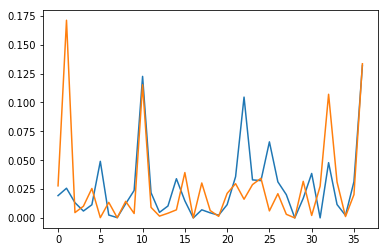

In [382]:
print(len(mistakes))
index_add = int(0.8 * len(data_raw))
error_count = 0
for i,g in enumerate(guesses2):
    probs = model.predict_proba(x_test)[i]
    sorted_probs = sorted(probs)
    max_prob = sorted_probs[-1]
    second_max = sorted_probs[-2]
    
    if max(probs) < 0.2:
        error_count += 1
        bad_file = random_files[index_add + i]
        
        print(f"mistake_id: {i}")
        print(f"model confidence: {max(probs)}")
        print("GUESS:", guesses2[i], "\nLABEL:", (truths2[i]))
        print("FILE PATH", bad_file)
        print("MAX PROB", max(probs))
        print("STD {:.4}".format((np.std(probs))))
        display(ipd.Audio(bad_file))
        print("-" * 100)
        plt.plot(probs)
        
print(f"total errors: {error_count}")

In [394]:
# mixing trimmed guitar with violin
guitar_sounds = glob.glob("dataset/all-samples/my_guitar_trimmed/*.mp3")
violin_sounds = glob.glob("dataset/all-samples/my_violin/*.mp3")

mix_sounds(guitar_sounds, violin_sounds, output_path="dataset/mixes5/")

guitar_A2_very-long_forte_normal guitar_A3_very-long_forte_normal guitar_A4_very-long_forte_normal guitar_As2_very-long_forte_normal guitar_As3_very-long_forte_normal guitar_As4_very-long_forte_normal guitar_B2_very-long_forte_normal guitar_B3_very-long_forte_normal guitar_B4_very-long_forte_normal guitar_C3_very-long_forte_normal guitar_C4_very-long_forte_normal guitar_Cs3_very-long_forte_normal guitar_Cs4_very-long_forte_normal guitar_D3_very-long_forte_normal guitar_D4_very-long_forte_normal guitar_D5_very-long_forte_normal guitar_Ds3_very-long_forte_normal guitar_Ds4_very-long_forte_normal guitar_Ds5_very-long_forte_normal guitar_E2_very-long_forte_normal guitar_E3_very-long_forte_normal guitar_E4_very-long_forte_normal guitar_E5_very-long_forte_normal guitar_F2_very-long_forte_normal guitar_F3_very-long_forte_normal guitar_F4_very-long_forte_normal guitar_Fs2_very-long_forte_normal guitar_Fs3_very-long_forte_normal guitar_Fs4_very-long_forte_normal guitar_G2_very-long_forte_normal

Takes violin & guitar mixes with flute & guitar mixes as dataset for model

In [97]:
# Randomizing dataset
all_files = glob.glob("dataset/mixes5/*.mp3") +  glob.glob("dataset/mixes4/*.mp3")
random.seed(2019)
random_files = all_files.copy()
random.shuffle(random_files)

labels = []
for f in random_files:
    labels.append((mutagen.File(f)['TXXX:sound1'].text[0]))
    
print("Done")
# print(labels[:10])

Done


In [407]:
# prepare dataset

data_raw = []

POWERS_OF_TWO = [2 ** i for i in range(16)]
print(f"loading {len(random_files)} files with librosa...")
for i, file_name in enumerate(random_files): # random_files -> all_files
 
    if i in POWERS_OF_TWO:
        print(i)
        
    track, sr = librosa_load_cached(file_name)
    data_raw.append(track)

print(len(data_raw))

loading 925 files with librosa...
1
2
4
8
16
32
64
128
256
512
925


In [163]:
sizes = list(map(len, data_raw))
biggest_file = random_files[sizes.index(max(sizes))]

In [247]:
# split data, ,and fit

# expect: randomized data set, no stft.
x_train, x_test, y_train, y_test = train_test_split(data_raw, labels, test_size=0.2, shuffle=False)

print("building dataframe1...")
x_train = pd.DataFrame(x_train).fillna(0)

print("building dataframe2...")
x_test = pd.DataFrame(x_test).fillna(0)

print("building series1...")
y_train = pd.Series(y_train)

print("building series2...")
y_test = pd.Series(y_test)

print("training...")
model = MLPC()

model.fit(x_train, y_train)

building dataframe1...
building dataframe2...
building series1...
building series2...
training...


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [248]:
# model verification over train
guesses = predict_with_default(model, x_train)
truths = y_train

results = np.array(guesses == truths)
print(f"{(results.sum() / len(results) * 100)}% over TRAINING set")

100.0% over TRAINING set


In [249]:
# test and show mistakes ...
guesses2 = predict_with_default(model, x_test) # model.predict(x_test)
truths2 = y_test

results = np.array(guesses2 == truths2)
print(f"{(results.sum() / len(results) * 100)}% over TESTING set")

mistakes = np.argwhere(~results).T[0]
index_add = int(0.8 * len(data_raw))

for m in mistakes:
    print(random_files[index_add + m])
    print("our_guess", guesses2[m])
    print("real_value:", truths2[m])
    display(ipd.Audio(random_files[index_add + m]))

98.37837837837839% over TESTING set
dataset/mixes4\guitar_Ds5_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess E5
real_value: DS5


dataset/mixes4\guitar_G2_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess E3
real_value: G2


dataset/mixes4\guitar_Gs5_very-long_forte_normalflute_A6_15_forte_normal.mp3
our_guess E5
real_value: GS5


visual & audial mistakes analyzing

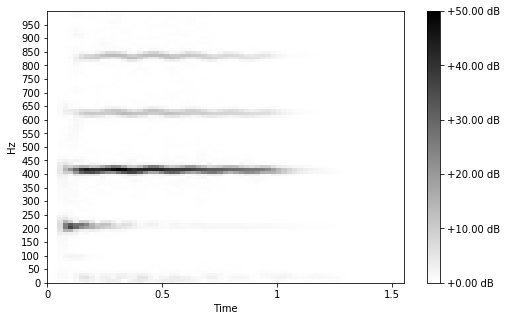

------------------------------


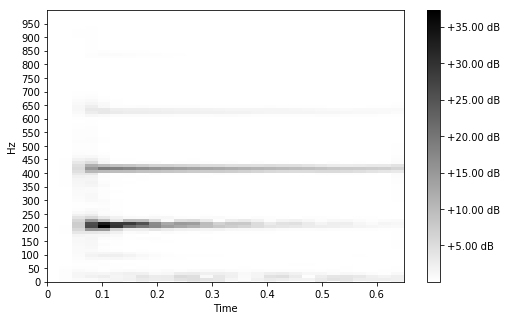

------------------------------


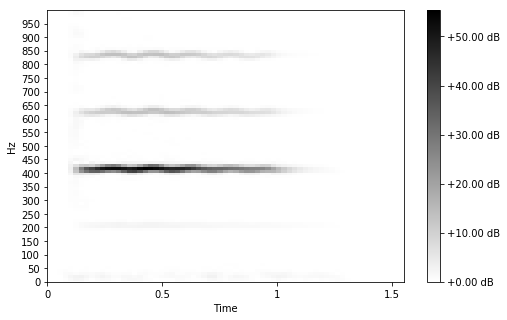

------------------------------


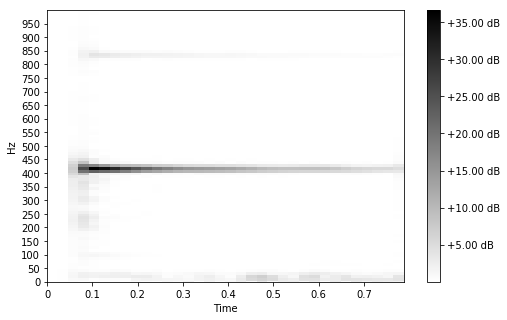

------------------------------


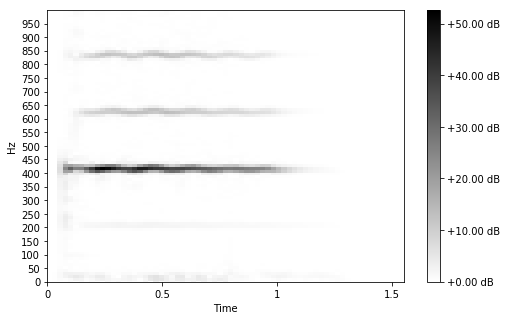

------------------------------


In [96]:
# print(random_files)
track1 = "dataset/mixes5\\guitar_Gs3_very-long_forte_normalviolin_Gs3_1_forte_arco-normal.mp3"
track2 = "dataset/all-samples/my_guitar_trimmed\guitar_Gs3_very-long_forte_normal.mp3"
track3 = "dataset/all-samples/my_violin/violin_Gs3_1_forte_arco-normal.mp3"
track4 = "dataset/all-samples/my_guitar_trimmed\guitar_Gs4_very-long_forte_normal.mp3"
track5 = "dataset/mixes5\\guitar_Gs4_very-long_forte_normalviolin_Gs3_1_forte_arco-normal.mp3"

tracks = [track1, track2, track3, track4, track5] # [same_time_track, guitar_track, flute_track]
for t in tracks:
    sound, sample_rate = librosa.load(t, duration=4.)
    fft_sound = librosa.stft(sound)
    plot_wavelength(fft_sound, sample_rate)
    display(ipd.Audio(t))
    print("-" * 30)

## New (electric) guitar test

In [344]:
fender_guitar_folder = r"C:\Users\Itay\Documents\university\workshop\dataset\new_guitar"
# fender_guitar_folder = r"C:\Users\Itay\Documents\university\workshop\dataset\effects\distortion"
files = glob.glob(fender_guitar_folder + "/*.wav")
new_data = []
new_labels = []
for file_name in files:
    #print(file_name)
    track, sr = librosa.load(file_name, duration=1.541) #2.06476)
    new_data.append(track)
    label = file_name.split('-')[-1][:-4]
    new_labels.append( label )
    
new_data.append(librosa.load(biggest_file)[0])
new_labels.append(re.findall("guitar_(.*?)_", biggest_file)[0])
files.append(biggest_file)
# pprint.pprint(new_labels)

In [345]:
test_x = pd.DataFrame(new_data).fillna(0)
test_y = pd.Series(new_labels)

print(test_x.shape)
print(sorted(set(new_labels)))

(79, 33979)
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C2', 'C3', 'C4', 'CS2', 'CS3', 'CS4', 'D2', 'D3', 'D4', 'DS2', 'DS3', 'DS4', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'GS2', 'GS3', 'GS4']


In [347]:
guesses3 = predict_with_default(model, test_x, 0)
print((((guesses3) == "NoG").sum()) / len(guesses3) * 100, "% no guitar guesses")
results = np.array(guesses3 == test_y)
print(f"{(results.sum() / len(results) * 100)}% success rate over new guitar set")
#print(len(results))
#print(len(new_labels))
print(np.array(new_labels)[results])
success_files = np.array(files)[results]
pprint.pprint(list(map(lambda x: x.split('\\')[-1], success_files)))

for f in success_files:
    display(ipd.Audio(f))

0.0 % no guitar guesses
13.924050632911392% success rate over new guitar set
['A2' 'E3' 'F3' 'G3' 'B3' 'B3' 'D3' 'F4' 'F4' 'A4' 'E3']
['G53-45105-1111-00006-A2.wav',
 'G53-52302-1111-00029-E3.wav',
 'G53-53208-1111-00022-F3.wav',
 'G53-55400-1111-00040-G3.wav',
 'G53-59309-1111-00036-B3.wav',
 'G53-59404-1111-00044-B3.wav',
 'G53-62312-1111-00039-D3.wav',
 'G53-65506-1111-00059-F4.wav',
 'G53-65601-1111-00067-F4.wav',
 'G53-69510-1111-00063-A4.wav',
 'slow_tempoguitar_E3_very-long_forte_normalflute_As6_15_forte_normal.mp3']


it seems like our project has reeached a deadend since we can't find more reliable dataset.
(see discussion above).

however another approach can be taken for enlarging the dataset - data augmentation.
<h2> data augmentation </h2>
Data augmentation is generally used for machine learning and deep learning in order to achieve a good performance after training generating a large amount of data. There are some data augmentation techniques such as; image augmentation, audio augmentation. These are used for image processing and speech processing studies. On the internet, there are excessively stories, tutorials and codes about image augmentation techniques. Unlike image augmentation techniques, there is not enough information about audio data augmentation techniques.

<h2> current approach </h2>
- using "guitar effects" over the original dataset to create more guitar sounds "span", thus dealing with overfitting!
<br> - adding random tiny noise to prevent "dumb" overfitting...

In [25]:
!pip install pysndfx
# Linux: !conda install -c conda-forge sox
# Windows: !conda install -c groakat sox
# also installed pyo from http://ajaxsoundstudio.com/software/pyo/

In [44]:
!pip install sox # SOX SHOULD BE INSTALLED IN CONDA
# https://stackoverflow.com/questions/3537155/sox-fail-util-unable-to-load-mad-decoder-library-libmad-function-mad-stream
# to support MP3: https://app.box.com/s/tzn5ohyh90viedu3u90w2l2pmp2bl41t
# libmad-0.dll
# libmp3lame-0.dll

In [9]:
fx = (
    AudioEffectsChain()
    .highshelf()
    .reverb()
    .phaser()
    .delay()
    .lowshelf()
)

In [10]:
indir = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\my_guitar_trimmed"
outdir = r"C:\Users\Itay\Documents\university\workshop\dataset\effects"
filename = "guitar_A4_very-long_forte_normal.mp3"

infile = os.path.join(indir,filename)
outfile = os.path.join(outdir,filename)

#d = open(infile, "rb").read()
#print(infile)
# Apply phaser and reverb directly to an audio file.
fx(infile, outfile)

# Or, apply the effects directly to a ndarray.
#from librosa import load
#y, sr = load(infile, sr=None)
#y = fx(y)

# Apply the effects and return the results as a ndarray.
#y = fx(infile)

# Apply the effects to a ndarray but store the resulting audio to disk.
#fx(y, outfile)
display(ipd.Audio(infile))
display(ipd.Audio(outfile))

Works like charm :-) now applying to all files

In [316]:
indir = r"C:\Users\Itay\Documents\university\workshop\dataset\all-samples\my_guitar_trimmed"
outdir = r"C:\Users\Itay\Documents\university\workshop\dataset\effects"
fx = (AudioEffectsChain().overdrive(gain=40))
fx2 = (AudioEffectsChain().reverb(reverberance=100, hf_damping=100, pre_delay=0, wet_gain=10))
fx3 = (AudioEffectsChain().tempo(0.5))
fx4 = (AudioEffectsChain().tempo(2))

effects_dir = ["distortion", "reverb", "slow_tempo", "fast_tempo"]
fxs = [fx, fx2, fx3, fx4]

files = glob.glob(os.path.join(indir, "*.mp3"))
for filepath in files:
    filename = os.path.basename(filepath)
    infile = os.path.join(indir,filename)
    for effect_dir, effect in zip(effects_dir, fxs):
        outfile = os.path.join(outdir,effect_dir,effect_dir+filename)
        effect(infile, outfile)

In [325]:
guitar_sounds = glob.glob("dataset/effects/*/*.mp3")
flute_sounds = glob.glob("dataset/all-samples/my_flute/*.mp3")

mix_sounds(guitar_sounds, flute_sounds, "dataset/mixes_effects")

distortionguitar_A2_very-long_forte_normal distortionguitar_A3_very-long_forte_normal distortionguitar_A4_very-long_forte_normal distortionguitar_As2_very-long_forte_normal distortionguitar_As3_very-long_forte_normal distortionguitar_As4_very-long_forte_normal distortionguitar_B2_very-long_forte_normal distortionguitar_B3_very-long_forte_normal distortionguitar_B4_very-long_forte_normal distortionguitar_C3_very-long_forte_normal distortionguitar_C4_very-long_forte_normal distortionguitar_Cs3_very-long_forte_normal distortionguitar_Cs4_very-long_forte_normal distortionguitar_D3_very-long_forte_normal distortionguitar_D4_very-long_forte_normal distortionguitar_D5_very-long_forte_normal distortionguitar_Ds3_very-long_forte_normal distortionguitar_Ds4_very-long_forte_normal distortionguitar_Ds5_very-long_forte_normal distortionguitar_E2_very-long_forte_normal distortionguitar_E3_very-long_forte_normal distortionguitar_E4_very-long_forte_normal distortionguitar_E5_very-long_forte_normal dis

<h2> Model with augmented data </h2>

In [4]:
# Randomizing dataset
all_files = glob.glob("dataset/mixes_effects/*.mp3")
#all_files = glob.glob("dataset/effects/*/*.mp3") +  glob.glob("dataset/mixes4/*.mp3")
#all_files = glob.glob("dataset/mixes4/*.mp3")
random.seed(2019)
random_files = all_files.copy()
random.shuffle(random_files)

labels = []
for f in random_files:
    label = re.findall("guitar_(.*?)_", f)[0]
    labels.append(label)
    
print("Done")
print(sorted(set(labels)))
# print(labels[:10])

Done
['A2', 'A3', 'A4', 'As2', 'As3', 'As4', 'B2', 'B3', 'B4', 'C3', 'C4', 'Cs3', 'Cs4', 'D3', 'D4', 'D5', 'Ds3', 'Ds4', 'Ds5', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'Fs2', 'Fs3', 'Fs4', 'G2', 'G3', 'G4', 'G5', 'Gs2', 'Gs3', 'Gs4', 'Gs5']


In [334]:
# prepare dataset

data_raw = []

POWERS_OF_TWO = [2 ** i for i in range(16)]
print(f"loading {len(random_files)} files with librosa...")
for i, file_name in enumerate(random_files): # random_files -> all_files
 
    if i in POWERS_OF_TWO:
        print(i, end=" ")
        
    track, sr = librosa_load_cached(file_name)
    data_raw.append(track)

print(len(data_raw))

loading 3700 files with librosa...
1 2 4 8 16 32 64 128 256 512 1024 2048 3700


In [338]:
sizes = list(map(len, data_raw))
biggest_file = random_files[sizes.index(max(sizes))]
print(max(sizes))

33979


In [336]:
# split data, ,and fit

# expect: randomized data set, no stft.
x_train, x_test, y_train, y_test = train_test_split(data_raw, labels, test_size=0.2, shuffle=False)

print("building dataframe1...")
x_train = pd.DataFrame(x_train).fillna(0)

print("building dataframe2...")
x_test = pd.DataFrame(x_test).fillna(0)

print("building series1...")
y_train = pd.Series(y_train)

print("building series2...")
y_test = pd.Series(y_test)

building dataframe1...
building dataframe2...
building series1...
building series2...


In [337]:
print("training...")
print("Train shape:", x_train.shape)
model = MLPC(early_stopping=True)

model.fit(x_train, y_train)

training...
Train shape: (2960, 33979)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [339]:
# model verification over train
guesses = predict_with_default(model, x_train, 0)
truths = y_train

results = np.array(guesses == truths)
print(f"{(results.sum() / len(results) * 100)}% over TRAINING set")

99.79729729729729% over TRAINING set


In [340]:
# test and show mistakes ...
guesses2 = predict_with_default(model, x_test, 0) # model.predict(x_test)
truths2 = y_test

results = np.array(guesses2 == truths2)
print(f"{(results.sum() / len(results) * 100)}% over TESTING set")

mistakes = np.argwhere(~results).T[0]
index_add = int(0.8 * len(data_raw))

for m in mistakes:
    break
    print(random_files[index_add + m])
    print("our_guess", guesses2[m])
    print("real_value:", truths2[m])
    display(ipd.Audio(random_files[index_add + m]))

99.05405405405405% over TESTING set


<h2> New Insights </h2>

    - electric guitar model is actually better than random!
        - when not using the confidence, no-guitar const
        -- 17% sucess rate out of ~ 24 options...
        -- ~14% after using data augmentation techniques
    
    - the problem with the mixes is probably the repetitions of same tracks...
    - using (early_stopping=True) might help a bit with the overfitting problem.
        -- also increase performance speed
    - the data augmentation doesn't seem to improve the success rate of the electric guitar. 
        
----------------------
<h2> New Conclusions: </h2>

    - Our dataset is not representive!
    
    - Getting more data is tough:
        - buying.
        - augmenting.
        - couldn't find available data online.
        - changing the approach and using "guitar-only-songs" and their notes.
        
    - Data augmentation techniques weren't helpful with our approach.
    
    - Our approach includes repetitions which probably increase the overfittnes.
    
    - We shouldn't have been satsified with the MPLC results
        - they were impressive only due to overfitting.
        - MPLC might no be "powerfull" enough to classify instrument sounds correctly.
        
    - The "native" approach of FFT and CNN is more promising.
    
-----------------------
<h2> New Approaches: </h2>

    by understanding the problem and its constrains more deeply,
    we can come up with new approaches.
    
    1. getting representative dataset:
        - try finding a different instrument, where data is easily available
        - if the dataset achieved is representative overfitting will be avoided.
        - models assesment will be straightforward. (since data errors won't occur)
        
    2. overcoming representative dataset:
    
        guitar_track & other_instrument_tracks
        
        build dataset:
        for guitar_track in guitar_tracks:
            guitar_track2 = random_effect(guitar_track) # noise cancling
            instrument_track = get_random_instrument_track()
            mix(guitar_track2, instrument_track) # no repetition of the guitar tracks
            
        for track in dataset:
            fft(track) # features will have intuitive representation
            
        model = CNN() # widely used for audio / image machine learning models
        
        model_verify(eletric_guitar_tracks) # verify over unseen data 

<hr>
<h2> New Approach PoC </h2>
OK, so we wanted to verify our intuition by showing the using FFT will improve our model results.
There are currently 2 issues to solve:
<br> - Will FFT help with model prediction rates?
<br> - What did the "old" model learn ? (somehow it has 15% prediction rate)

<br> Actually a bug with our labeling was found, increasing the model success rate to 20%. (the sharp symbol was lowercase in the classical guitar data-set, and uppercase in the electrical guitar...)
<br> this success rate is really high, but it cannot be neglected

In [ ]:
@functools.lru_cache(maxsize=4096, typed=False)
def librosa_load_cached(file_name):
    return librosa.load(file_name)

In [10]:
def track_to_fft(track):
    #return track
    #  # track
    #x = scipy.signal.spectrogram(track, fs=22050)[2]
    #return x.mean(1)
    
    a = scipy.signal.spectrogram(track, fs=22050, nperseg=5000)
    #b = pd.Series(a[2].mean(1)).apply(lambda z: log(z))
    x = a[2].mean(1)
    m = x.mean()
    s = x.std()
    x_scaled = (x-m)/s
    #x_scaled = min_max_scaler.fit_transform(x)
    #plot(x_scaled)
    return x_scaled
    #print(x.shape)
    #x = abs(scipy.signal.stft(track)[2])
    #new_shape = x.shape[0] * x.shape[1]
    return pd.Series().apply(lambda z: z) #.reshape(1, new_shape)[0]

full classical-guitar training & testing ... (to ease up the research process)

In [85]:
def full_classical_guitar(fft_func):
    
    # Randomizing dataset
    all_files = glob.glob("dataset/mixes4/*.mp3")

    random.seed(2019)
    random_files = all_files.copy()
    random.shuffle(random_files)

    labels = []
    for f in random_files:
        label = re.findall("guitar_(.*?)_", f)[0].upper()
        labels.append(label)

    print("created data with labels")
    print(sorted(set(labels)))

    # prepare dataset
    data_raw = []

    POWERS_OF_TWO = [2 ** i for i in range(16)]
    print(f"loading {len(random_files)} files with librosa...")
    for i, file_name in enumerate(random_files): # random_files -> all_files

        if i in POWERS_OF_TWO:
            print(i, end=" ")

        track, sr = librosa_load_cached(file_name)
        data_raw.append(fft_func(track))

    print(len(data_raw))

    sizes = list(map(len, data_raw))
    biggest_file = random_files[sizes.index(max(sizes))]
    print(max(sizes))

    # split data, ,and fit

    # expect: randomized data set, no stft.
    x_train, x_test, y_train, y_test = train_test_split(data_raw, labels, test_size=0.2, shuffle=False)

    print("building dataframe1...")
    x_train = pd.DataFrame(x_train).fillna(0)

    print("building dataframe2...")
    x_test = pd.DataFrame(x_test).fillna(0)

    print("building series1...")
    y_train = pd.Series(y_train)

    print("building series2...")
    y_test = pd.Series(y_test)

    print("training....")
    # model = MLPC(activation='tanh', verbose=False, early_stopping=True)
    model = MLPC(activation='tanh', verbose=False, early_stopping=True)
    print(x_train.shape)
    model.fit(x_train, y_train)

    print("predicting....")
    # model verification over train
    guesses = model.predict(x_train)
    truths = y_train

    results = np.array(guesses == truths)
    print(f"{(results.sum() / len(results) * 100)}% over TRAINING set")

    # test and show mistakes ...
    guesses2 = model.predict(x_test)
    truths2 = y_test

    results = np.array(guesses2 == truths2)
    print(f"{(results.sum() / len(results) * 100)}% over TESTING set")

    mistakes = np.argwhere(~results).T[0]
    index_add = int(0.8 * len(data_raw))

    #for m in mistakes:
    #    print(random_files[index_add + m])
    #    print("our_guess", guesses2[m])
    #    print("real_value:", truths2[m])
    #    display(ipd.Audio(random_files[index_add + m]))
    return model, mistakes

In [86]:
def full_electric_guitar(trained_model, fft_func):
    fender_guitar_folder = r"C:\Users\Itay\Documents\university\workshop\dataset\new_guitar"
    # fender_guitar_folder = r"C:\Users\Itay\Documents\university\workshop\dataset\effects\distortion"
    files = glob.glob(fender_guitar_folder + "/*.wav")
    new_data = []
    new_labels = []
    for file_name in files:
        #print(file_name)
        track, sr = librosa.load(file_name, duration=1.541) #2.06476)
        new_data.append(fft_func(track))
        label = file_name.split('-')[-1][:-4]
        new_labels.append( label )

    new_data.append(fft_func(librosa.load(biggest_file)[0]))
    new_labels.append(re.findall("guitar_(.*?)_", biggest_file)[0])
    files.append(biggest_file)
    # pprint.pprint(new_labels)

    test_x = pd.DataFrame(new_data).fillna(0)
    test_y = pd.Series(new_labels)

    # last data was only added for padding ...
    files = files[:-1]
    new_data = new_data[:-1]
    new_labels = new_labels[:-1]
    test_x = test_x[:-1]
    test_y = test_y[:-1]


    print(test_x.shape)
    print(sorted(set(new_labels)))

    guesses3 = trained_model.predict(test_x)
    results = np.array(guesses3 == test_y)
    print(f"{(results.sum() / len(results) * 100):.3}% success rate over new guitar set")
    #print(len(results))
    #print(len(new_labels))
    #print(np.array(new_labels)[results])
    success_files = np.array(files)[results]
   # pprint.pprint(list(map(lambda x: x.split('\\')[-1], success_files)))

    #for f in success_files:
    #    display(ipd.Audio(f))
    mistakes = np.argwhere(~results).T[0]
    return mistakes

In [50]:
def track_to_fft(track):
    return list(map(lambda x: abs(x), np.fft.fft(track)))

model, mistakes = full_classical_guitar(track_to_fft)
full_electric_guitar(model, track_to_fft)

created data with labels
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C3', 'C4', 'CS3', 'CS4', 'D3', 'D4', 'D5', 'DS3', 'DS4', 'DS5', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'G5', 'GS2', 'GS3', 'GS4', 'GS5']
loading 962 files with librosa...
1 2 4 8 16 32 64 128 256 512 962
33979
building dataframe1...
building dataframe2...
building series1...
building series2...
training....
(769, 33979)
predicting....
25.097529258777634% over TRAINING set
8.290155440414509% over TESTING set
(78, 33979)
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C2', 'C3', 'C4', 'CS2', 'CS3', 'CS4', 'D2', 'D3', 'D4', 'DS2', 'DS3', 'DS4', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'GS2', 'GS3', 'GS4']
8.97% success rate over new guitar set


array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74,
       75, 76, 77], dtype=int64)

Attempt1: absolute value over FFT over track
<br> Results1: awful results (~9% over test-set)
<br> Idea2: using stft

In [51]:
def track_to_fft(track):
    x = abs(scipy.signal.stft(track)[2])
    return x.flatten()

model, mistakes = full_classical_guitar(track_to_fft)
full_electric_guitar(model, track_to_fft)

created data with labels
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C3', 'C4', 'CS3', 'CS4', 'D3', 'D4', 'D5', 'DS3', 'DS4', 'DS5', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'G5', 'GS2', 'GS3', 'GS4', 'GS5']
loading 962 files with librosa...
1 2 4 8 16 32 64 128 256 512 962
34443
building dataframe1...
building dataframe2...
building series1...
building series2...
training....
(769, 34443)
predicting....
84.39531859557867% over TRAINING set
38.34196891191709% over TESTING set
(78, 34443)
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C2', 'C3', 'C4', 'CS2', 'CS3', 'CS4', 'D2', 'D3', 'D4', 'DS2', 'DS3', 'DS4', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'GS2', 'GS3', 'GS4']
3.85% success rate over new guitar set


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76], dtype=int64)

Attempt2: STFT over track
<br> Results2: awful results (~4% over electric guitar)
<br> Idea3: using spectogram (a matrix is returned: x,y axis are time and frequency. A[x][y] = intensity

In [53]:
def track_to_fft(track):
    a = scipy.signal.spectrogram(track, fs=22050, nperseg=5000)
    return a[2].mean(1) # avg over time

model, mistakes = full_classical_guitar(track_to_fft)
full_electric_guitar(model, track_to_fft)

created data with labels
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C3', 'C4', 'CS3', 'CS4', 'D3', 'D4', 'D5', 'DS3', 'DS4', 'DS5', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'G5', 'GS2', 'GS3', 'GS4', 'GS5']
loading 962 files with librosa...
1 2 4 8 16 32 64 128 256 512 962
2501
building dataframe1...
building dataframe2...
building series1...
building series2...
training....
(769, 2501)
predicting....
2.860858257477243% over TRAINING set
2.072538860103627% over TESTING set
(78, 2501)
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C2', 'C3', 'C4', 'CS2', 'CS3', 'CS4', 'D2', 'D3', 'D4', 'DS2', 'DS3', 'DS4', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'GS2', 'GS3', 'GS4']
2.56% success rate over new guitar set


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 73, 74, 75, 76, 77], dtype=int64)

Results3: even worse. the model is not able to overfit the trainset data...
<br> something is very wrong here...
<br> let's visualize the data:

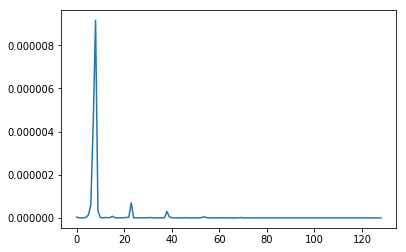

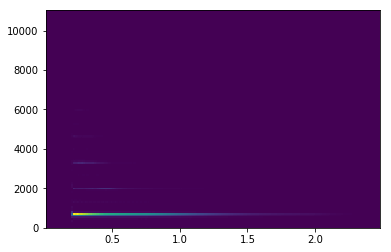

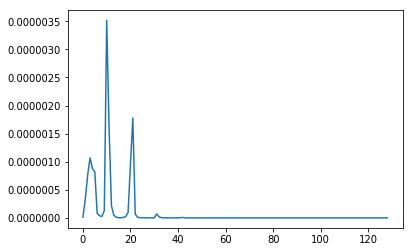

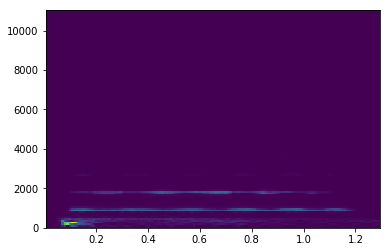

In [69]:
file_name1 = "C:\\Users\\Itay\\Documents\\university\\workshop\\dataset\\new_guitar\\G53-76612-1111-00078-E5.wav"
file_name2 = "C:\\Users\\Itay\\Documents\\university\\workshop\\dataset\\mixes4\\guitar_A2_very-long_forte_normalflute_A5_15_forte_normal.mp3"
for file_name in [file_name1, file_name2]:
    track, sr = librosa_load_cached(file_name)
    a = scipy.signal.spectrogram(track, fs=22050)
    x = a[2].mean(1)
    plot(x)
    plt.show()
    plt.pcolor(a[1], a[0], a[2])
    plt.show()

Data Visualization looks as expected... We'll get to it later.
<br> Now We'll try to understand what the classical_guitar model was able to learn
<br> by looking at the electric guitar mistakes

In [72]:
model, mistakes = full_classical_guitar(lambda x: x)
electric_mistakes = full_electric_guitar(model, lambda x: x)

In [73]:
for m in electric_mistakes:
    print(files[m])
    print("our_guess", guesses3[m], end= " ")
    print("real_value:", test_y[m])

C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-40100-1111-00001-E2.wav
our_guess CS3 real_value: E2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-41101-1111-00002-F2.wav
our_guess A4 real_value: F2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-43103-1111-00004-G2.wav
our_guess G3 real_value: G2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-44104-1111-00005-GS2.wav
our_guess CS3 real_value: GS2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-45105-1111-00006-A2.wav
our_guess A3 real_value: A2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-45200-1111-00014-A2.wav
our_guess A3 real_value: A2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-46201-1111-00015-AS2.wav
our_guess AS3 real_value: AS2
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-48108-1111-00009-C2.wav
our_guess F2 real_value: C2
C:\Users\Itay\Documents\university\worksh

This is quite thrilling! most of the mistakes are for same notes in different octaves!!
<br> the model has learned something related to the played frequencies!
<br> also a good idea will be seperating the mistakes by their tone-differences.

C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-40100-1111-00001-E2.wav
our_guess CS3 real_value: E2
diff 9
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-41101-1111-00002-F2.wav
our_guess A4 real_value: F2
diff 4
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-43103-1111-00004-G2.wav
our_guess G3 real_value: G2
diff 0
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-44104-1111-00005-GS2.wav
our_guess CS3 real_value: GS2
diff 5
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-45105-1111-00006-A2.wav
our_guess A3 real_value: A2
diff 0
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-45200-1111-00014-A2.wav
our_guess A3 real_value: A2
diff 0
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-46201-1111-00015-AS2.wav
our_guess AS3 real_value: AS2
diff 0
C:\Users\Itay\Documents\university\workshop\dataset\new_guitar\G53-48108-1111-00009-C2.wav
our_guess F2 real_va

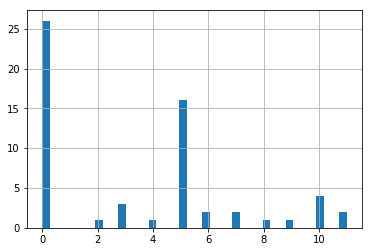

In [74]:
notes_map = {'C' : 0, 'Cs' : 1, 'D' : 2, 'Ds' : 3, 'E' : 4, 'F' : 5, 'Fs' : 6, 'G' : 7, 'Gs' : 8, 'A' : 9, 'As' : 10, 'B' : 11}

diffs = []
for m in electric_mistakes:
    
    print(files[m])
    print("our_guess", guesses3[m], end= " ")
    print("real_value:", test_y[m])
    add = 0
    if 'S' in guesses3[m]:
        add = 1
    if 'S' in test_y[m]:
        add -= 1
    diff = notes_map[guesses3[m][0]] - notes_map[test_y[m][0]] + add
    if diff < 0:
        diff += 12
    print("diff", diff)
    diffs.append(diff)
    #display(ipd.Audio(files[index_add + m]))

pd.Series(diffs).hist(bins=40)


Another thrilling result!
<br> our model is mostly wrong when it comes to octaves
<br> but it also has lots of mistakes when the difference is 'quinta'
<br> notes seperated by a 'quinta' or 5 half-tones are similiar! (both to the human ear, and by frequency wave length)
<br> the freqency quotent between 2 quotient is 2
<br> the freqency quotent between 2 quotient is 1.5
<hr>
<br> This means that our dataset is not as bad as we thought
<br> our model was able to learn the FT, and understand something about the waves frequenvies.
<br> it also means that our intuition regarding using FFT is good and we need go back to it
<hr>
<br> By looking at the data visualization graph, and the input vector for the Nerual Network,
<br> it is clear that the values are extremely small
<br> it is also clear that in our last attempt, our model failed to learn anything! though even with random inputs it should overfit a bit...
<hr>
<br> this lead us to our final attempt: <b> input normalization </b>!

In [75]:
def track_to_fft(track):
    a = scipy.signal.spectrogram(track, fs=22050, nperseg=5000)
    x = a[2].mean(1) # avg over time
    m = x.mean()
    s = x.std()
    x_scaled = (x-m)/s
    return x_scaled

model, mistakes = full_classical_guitar(track_to_fft)
full_electric_guitar(model, track_to_fft)

created data with labels
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C3', 'C4', 'CS3', 'CS4', 'D3', 'D4', 'D5', 'DS3', 'DS4', 'DS5', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'G5', 'GS2', 'GS3', 'GS4', 'GS5']
loading 962 files with librosa...
1 2 4 8 16 32 64 128 256 512 962
2501
building dataframe1...
building dataframe2...
building series1...
building series2...
training....
(769, 2501)
predicting....
94.79843953185956% over TRAINING set
77.2020725388601% over TESTING set
(78, 2501)
['A2', 'A3', 'A4', 'AS2', 'AS3', 'AS4', 'B2', 'B3', 'B4', 'C2', 'C3', 'C4', 'CS2', 'CS3', 'CS4', 'D2', 'D3', 'D4', 'DS2', 'DS3', 'DS4', 'E2', 'E3', 'E4', 'E5', 'F2', 'F3', 'F4', 'FS2', 'FS3', 'FS4', 'G2', 'G3', 'G4', 'GS2', 'GS3', 'GS4']
56.4% success rate over new guitar set


array([ 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 36, 39, 40, 41, 43,
       44, 46, 47, 48, 49, 50, 52, 56, 57, 59, 65, 66, 69, 70, 73, 75, 76],
      dtype=int64)

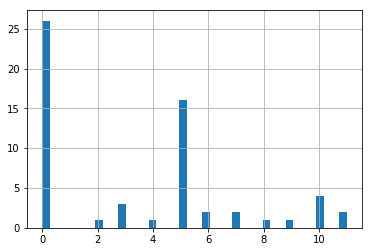

In [78]:
notes_map = {'C' : 0, 'Cs' : 1, 'D' : 2, 'Ds' : 3, 'E' : 4, 'F' : 5, 'Fs' : 6, 'G' : 7, 'Gs' : 8, 'A' : 9, 'As' : 10, 'B' : 11}

diffs = []
for m in electric_mistakes:
    
    #print(files[m])
    #print("our_guess", guesses3[m], end= " ")
    #print("real_value:", test_y[m])
    add = 0
    if 'S' in guesses3[m]:
        add = 1
    if 'S' in test_y[m]:
        add -= 1
    diff = notes_map[guesses3[m][0]] - notes_map[test_y[m][0]] + add
    if diff < 0:
        diff += 12
    #print("diff", diff)
    diffs.append(diff)
    #display(ipd.Audio(files[index_add + m]))

pd.Series(diffs).hist(bins=40)

We will also try changing the labels so that octaves won't take into account.
<br> This is sort of data-augmentation, and will help the model learn the notes themself.
<br> It is also useful for the guitar players in this way.

In [92]:
def full_classical_guitar(fft_func):
    
    # Randomizing dataset
    all_files = glob.glob("dataset/mixes4/*.mp3")

    random.seed(2019)
    random_files = all_files.copy()
    random.shuffle(random_files)

    labels = []
    for f in random_files:
        label = re.findall("guitar_(.*?)_", f)[0].upper()[:-1] # no octave
        labels.append(label)

    print("created data with labels")
    print(sorted(set(labels)))

    # prepare dataset
    data_raw = []

    POWERS_OF_TWO = [2 ** i for i in range(16)]
    print(f"loading {len(random_files)} files with librosa...")
    for i, file_name in enumerate(random_files): # random_files -> all_files

        if i in POWERS_OF_TWO:
            print(i, end=" ")

        track, sr = librosa_load_cached(file_name)
        data_raw.append(fft_func(track))

    print(len(data_raw))

    sizes = list(map(len, data_raw))
    biggest_file = random_files[sizes.index(max(sizes))]
    print(max(sizes))

    # split data, ,and fit

    # expect: randomized data set, no stft.
    x_train, x_test, y_train, y_test = train_test_split(data_raw, labels, test_size=0.2, shuffle=False)

    print("building dataframe1...")
    x_train = pd.DataFrame(x_train).fillna(0)

    print("building dataframe2...")
    x_test = pd.DataFrame(x_test).fillna(0)

    print("building series1...")
    y_train = pd.Series(y_train)

    print("building series2...")
    y_test = pd.Series(y_test)

    print("training....")
    # model = MLPC(activation='tanh', verbose=False, early_stopping=True)
    model = MLPC(activation='tanh', verbose=False, early_stopping=True)
    print(x_train.shape)
    model.fit(x_train, y_train)

    print("predicting....")
    # model verification over train
    guesses = model.predict(x_train)
    truths = y_train

    results = np.array(guesses == truths)
    print(f"{(results.sum() / len(results) * 100)}% over TRAINING set")

    # test and show mistakes ...
    guesses2 = model.predict(x_test)
    truths2 = y_test

    results = np.array(guesses2 == truths2)
    print(f"{(results.sum() / len(results) * 100)}% over TESTING set")

    mistakes = np.argwhere(~results).T[0]
    index_add = int(0.8 * len(data_raw))

    #for m in mistakes:
    #    print(random_files[index_add + m])
    #    print("our_guess", guesses2[m])
    #    print("real_value:", truths2[m])
    #    display(ipd.Audio(random_files[index_add + m]))
    return model, mistakes

In [102]:
def full_electric_guitar(trained_model, fft_func):
    fender_guitar_folder = r"C:\Users\Itay\Documents\university\workshop\dataset\new_guitar"
    # fender_guitar_folder = r"C:\Users\Itay\Documents\university\workshop\dataset\effects\distortion"
    files = glob.glob(fender_guitar_folder + "/*.wav")
    new_data = []
    new_labels = []
    for file_name in files:
        #print(file_name)
        track, sr = librosa.load(file_name, duration=1.541) #2.06476)
        new_data.append(fft_func(track))
        label = file_name.split('-')[-1][:-4][:-1] # no octave
        new_labels.append( label )

    new_data.append(fft_func(librosa.load(biggest_file)[0]))
    new_labels.append(re.findall("guitar_(.*?)_", biggest_file)[0])
    files.append(biggest_file)
    # pprint.pprint(new_labels)

    test_x = pd.DataFrame(new_data).fillna(0)
    test_y = pd.Series(new_labels)

    # last data was only added for padding ...
    files = files[:-1]
    new_data = new_data[:-1]
    new_labels = new_labels[:-1]
    test_x = test_x[:-1]
    test_y = test_y[:-1]


    print(test_x.shape)
    print(sorted(set(new_labels)))

    guesses3 = trained_model.predict(test_x)
    results = np.array(guesses3 == test_y)
    print(f"{(results.sum() / len(results) * 100):.3}% success rate over new guitar set")
    #print(len(results))
    #print(len(new_labels))
    #print(np.array(new_labels)[results])
    success_files = np.array(files)[results]
   # pprint.pprint(list(map(lambda x: x.split('\\')[-1], success_files)))

    #for f in success_files:
    #    display(ipd.Audio(f))
    mistakes = np.argwhere(~results).T[0]
    return mistakes, guesses3, test_y

In [103]:
def track_to_fft(track):
    a = scipy.signal.spectrogram(track, fs=22050, nperseg=5000)
    x = a[2].mean(1) # avg over time
    m = x.mean()
    s = x.std()
    x_scaled = (x-m)/s
    return x_scaled

model, mistakes = full_classical_guitar(track_to_fft)
electric_mistakes,guesses3, test_y = full_electric_guitar(model, track_to_fft)

(78, 2501)
['A', 'AS', 'B', 'C', 'CS', 'D', 'DS', 'E', 'F', 'FS', 'G', 'GS']
94.9% success rate over new guitar set


our_guess E real_value: B
our_guess CS real_value: GS
our_guess FS real_value: AS
our_guess FS real_value: AS


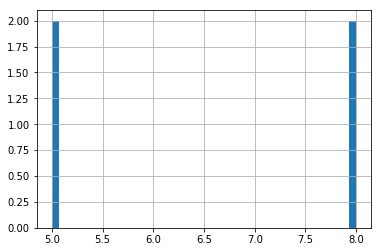

In [104]:
notes_map = {'C' : 0, 'Cs' : 1, 'D' : 2, 'Ds' : 3, 'E' : 4, 'F' : 5, 'Fs' : 6, 'G' : 7, 'Gs' : 8, 'A' : 9, 'As' : 10, 'B' : 11}

diffs = []
for m in electric_mistakes:
    
    #print(files[m])
    print("our_guess", guesses3[m], end= " ")
    print("real_value:", test_y[m])
    add = 0
    if 'S' in guesses3[m]:
        add = 1
    if 'S' in test_y[m]:
        add -= 1
    diff = notes_map[guesses3[m][0]] - notes_map[test_y[m][0]] + add
    if diff < 0:
        diff += 12
    #print("diff", diff)
    diffs.append(diff)
    #display(ipd.Audio(files[index_add + m]))

pd.Series(diffs).hist(bins=40)

<h2> Final Conclusions </h2>
<br> Everything is possible!!!!!! (The new success rate over the electric guitar is ~ 95% !!!)
<br> We have learned a lot, mainly by trying to figure out deep problems in our project.
<br> Surprisingly, our first intutions were great! however using ML can be complex and subtle.
<br> Models can't be used off-the-shelf without the data-scientist's understanding of its inner workings.
<br> Understaning the neural network input was imperative!
<br> Both for transforming the data by Fourier Transform, and also for normalization.
<br> As it turned out, the learning_rate of the neural network was just too big for the primal output of FT.
<br> Music understanding was also crucial as it explained the model's mistakes and gave them meaning. :-)

<br> We are also satisfied with our dedication to improve the model prediction rate.
<br> It wasn't the basic idea behind our initial approach that failed, but subtle understanding of ML inner workings.

<br> It also important to notice, the our model is able to both: identify completely new guitar sounds, and to seperate guitar sounds from other instruemnts!!
<br> since both the test-set (which is seperating guitar~flute sounds) and the electric-guitar prediction rates are high!

## Sources

[1] http://cs229.stanford.edu/proj2017/final-reports/5242716.pdf <br>
[2] http://kichiki.github.io/waon/ <br>
[3] https://homepages.inf.ed.ac.uk/dcspaul/homepage/live/pdf/msc_20172175.pdf <br>
[4] https://github.com/babaktr/musical-instrument-recognition <br>
[5] https://en.wikipedia.org/wiki/Blind_signal_separation <br>
[6] http://bass-db.gforge.inria.fr/fasst/FASST_UserGuide_v1.pdf <br>
[7] http://www.philharmonia.co.uk/explore/sound_samples <br>
[8] https://zenodo.org/record/1290750#.XJu2bygzZPY <br>
[9] https://magenta.tensorflow.org/ <br>
[10] https://arxiv.org/pdf/1812.00149.pdf <br>
[11] https://en.wikipedia.org/wiki/Mel-frequency_cepstrum <br>
[12] https://seafile.idmt.fraunhofer.de/d/e6ac75ab67/ <br>